# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:45<00:00, 22025.19it/s]
Cold Starts / total requests: 	 1217 / 897827
Cold Start Probability: 	 0.0014
Rejection / total requests: 	 0 / 897827
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6349.6107
Average Server Count:  		 7.7008
Average Running Count:  	 1.7868
Average Idle Count:  		 5.9140


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_time=100)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_time=100)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(6, 'u')        0.0005
(8, 'd')        0.0466
(7, 'd')        0.2852
(5, 'd')        0.0001
(12, 'd')       0.0000
(10, 'd')       0.0000
(11, 'u')       0.0048
(9, 'u')        0.1306
(8, 'u')        0.3180
(13, 'u')       0.0006
(12, 'u')       0.0012
(6, 'd')        0.0613
(10, 'u')       0.0332
(7, 'u')        0.1136
(11, 'd')       0.0000
(9, 'd')        0.0043


,state,prob,sojourn_time
3,"(5, d)",1.162334e-04,38.740604
11,"(6, d)",6.127122e-02,220.378104
0,"(6, u)",4.571229e-04,152.359102
2,"(7, d)",2.852019e-01,489.988792
13,"(7, u)",1.135997e-01,407.126598
1,"(8, d)",4.661872e-02,175.902135
8,"(8, u)",3.179985e-01,545.640436
15,"(9, d)",4.279008e-03,64.826982
7,"(9, u)",1.306307e-01,492.896717
5,"(10, d)",1.100151e-05,1.000038


## Calculate Average Transition Times

In [11]:
residence_times, transition_times, skip_init = sim.analyze_custom_states(hist_states, skip_init_time=100)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
13,"(5, d)","(6, u)",3,38.740604,3,1.000000
12,"(6, d)","(5, d)",3,402.704974,278,0.010791
4,"(6, d)","(7, u)",275,218.389083,278,0.989209
14,"(6, u)","(7, u)",3,152.359102,3,1.000000
2,"(7, d)","(8, u)",335,566.142719,582,0.575601
3,"(7, d)","(6, d)",247,386.703101,582,0.424399
15,"(7, u)","(6, d)",31,950.516712,279,0.111111
0,"(7, u)","(8, u)",248,339.202834,279,0.888889
11,"(8, d)","(9, u)",28,362.608234,265,0.105660
7,"(8, d)","(7, d)",237,153.844031,265,0.894340


## Calculate Transition Time Histograms

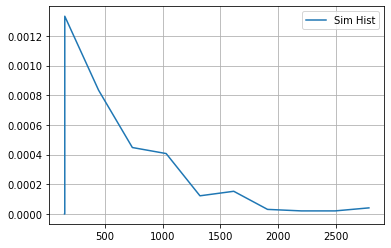

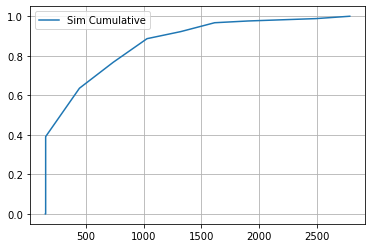

In [12]:
from pacssim.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Cold Start Probabily per State

In this section, we want to calculate the probability of a cold start occuring for a given state. This gives us a lot of insight about how to debug our performance model.

In [42]:
reqdf = sim.get_request_custom_states(hist_states=hist_states, skip_init_index=skip_init)
reqdf = reqdf.sort_values(by='state')
reqdf

,state,cold,warm,rej,total,p_cold
8,"(5, d)",3,109,0,112,0.026786
3,"(6, d)",275,54607,0,54882,0.005011
9,"(6, u)",3,463,0,466,0.006438
2,"(7, d)",335,255661,0,255996,0.001309
0,"(7, u)",248,101945,0,102193,0.002427
5,"(8, d)",28,41898,0,41926,0.000668
1,"(8, u)",237,285394,0,285631,0.000830
7,"(9, d)",0,3845,0,3845,0.000000
4,"(9, u)",66,117006,0,117072,0.000564
11,"(10, d)",0,12,0,12,0.000000


## Calculate Time Average of Server Count

Value           Prob
5               0.0001
6               0.0617
7               0.3988
8               0.3646
9               0.1349
10              0.0332
11              0.0048
12              0.0012
13              0.0006


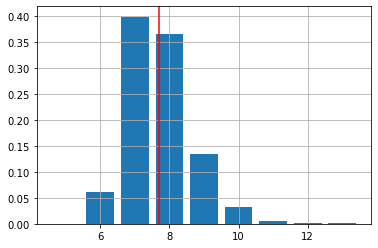

In [7]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [8]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000116
1,6,0.061728
2,7,0.398802
3,8,0.364617
4,9,0.134910
5,10,0.033217
6,11,0.004808
7,12,0.001202
8,13,0.000600
